In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaiknishath","key":"3071812f496b8336f82543f5d64b22ce"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download faresabbasai2022/skin-burn-dataset

 97% 105M/109M [00:05<00:00, 28.9MB/s]
100% 109M/109M [00:05<00:00, 21.7MB/s]


In [ ]:
! unzip skin-burn-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: skin burn dataset/train/1st degree burn/img352.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.230a0720bc02b7289806fd9d615b17cb.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.277114adf3996014a550c848f1f38350.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.2b3ac2c35f277219b993fbcde4d54359.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.402cf83af7811fde1fbdc995dbae6700.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.948efd87c5ee29eb8ecbede4e520df50.jpg  
  inflating: skin burn dataset/train/1st degree burn/img352_jpg.rf.a44a21afd6eb162d253950739552b6e2.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354_jpg.rf.9d74ca95ab64589aad0029abbb739821.jpg  
  inflating: skin burn dataset/train/1st degree burn/img354_jpg.rf.a397f59a

In [ ]:
train_path = "/content/skin burn dataset/train"
test_path = "/content/skin burn dataset/test"
valid_path = "/content/skin burn dataset/valid"

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
#from keras.utils.vis_utils import plot_model
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')
import os

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog
def extract_hog_features(image):
    # Calculate HOG features
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), visualize=False)
    return hog_features

In [ ]:
def load_and_extract_features(directory):
    X = []
    y = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            # Load image using OpenCV
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            # Noise removal (Gaussian blur)
            img = cv2.GaussianBlur(img, (5, 5), 0)
            # Morphological operations (erosion and dilation)
            kernel = np.ones((5, 5), np.uint8)
            img = cv2.erode(img, kernel, iterations=1)
            img = cv2.dilate(img, kernel, iterations=1)

            # Image segmentation (thresholding)
            _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            # Resize image to (128, 128)
            img_resized = cv2.resize(img, (128, 128))
            # Convert image to grayscale
            #img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            # Calculate HOG features
            hog_features = extract_hog_features(img_resized)
            X.append(hog_features)
            y.append(label)
    return X, y


In [ ]:
def load_and_extract_features(directory):
    X = []
    y = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            # Load image using OpenCV
            img = cv2.imread(image_path)
            # Resize image to (128, 128)
            img_resized = cv2.resize(img, (128, 128))
            # Convert image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            # Calculate HOG features
            hog_features = extract_hog_features(img_gray)
            X.append(hog_features)
            y.append(label)
    return X, y


In [ ]:
train_X, train_y = load_and_extract_features(train_path)


In [ ]:
test_X, test_y = load_and_extract_features(valid_path)


In [ ]:
def train_random_forest(X_train, y_train):
    rf_classifier = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5)
    rf_classifier.fit(X_train, y_train)
    return rf_classifier

In [ ]:
classifier = train_random_forest(train_X,train_y)

In [ ]:
predictions = classifier.predict(test_X)

In [ ]:
accuracy = accuracy_score(test_y,predictions)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
classification_rep = classification_report(test_y, predictions)

# Print the results
print(f"Random Forest Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)
rf_conf_matrix = confusion_matrix(test_y, predictions)

print("Confusion Matrix:")
print(rf_conf_matrix)

Random Forest Accuracy: 0.63

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.71      0.55      0.62       154
2nd degree burn       0.59      0.85      0.70       195
3nd degree burn       0.00      0.00      0.00        50

       accuracy                           0.63       399
      macro avg       0.44      0.47      0.44       399
   weighted avg       0.57      0.63      0.58       399

Confusion Matrix:
[[ 85  69   0]
 [ 29 166   0]
 [  5  45   0]]


In [ ]:
from sklearn.svm import SVC

def train_svm(X_train, y_train):
    # Initialize the SVM classifier
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    return svm_classifier

In [ ]:
svm_classifier = train_svm(train_X, train_y)

In [ ]:
svm_pred = svm_classifier.predict(test_X)
svm_accuracy = accuracy_score(test_y, svm_pred)
svm_classification_rep = classification_report(test_y,svm_pred)

# Print the results
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print("\nClassification Report:\n", svm_classification_rep)
svm_conf_matrix = confusion_matrix(test_y, svm_pred)

print("Confusion Matrix:")
print(svm_conf_matrix)

SVM Accuracy: 0.63

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.69      0.55      0.61       154
2nd degree burn       0.60      0.85      0.70       195
3nd degree burn       0.50      0.02      0.04        50

       accuracy                           0.63       399
      macro avg       0.60      0.47      0.45       399
   weighted avg       0.62      0.63      0.58       399

Confusion Matrix:
[[ 84  70   0]
 [ 29 165   1]
 [  9  40   1]]


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn(X_train, y_train, k=5):
    # Initialize a KNN classifier with specified hyperparameters
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Train the KNN classifier using the training data
    knn_classifier.fit(X_train, y_train)

    # Return the trained KNN classifier
    return knn_classifier

In [ ]:
classifier2 = train_knn(train_X,train_y)

In [ ]:
knn_pred = classifier2.predict(test_X)
knn_accuracy = accuracy_score(test_y, knn_pred)
knn_classification_rep = classification_report(test_y,knn_pred)

# Print the results
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("\nClassification Report:\n", knn_classification_rep)
knn_conf_matrix = confusion_matrix(test_y, knn_pred)

print("Confusion Matrix:")
print(knn_conf_matrix)

KNN Accuracy: 0.46

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.40      0.55      0.46       154
2nd degree burn       0.57      0.50      0.53       195
3nd degree burn       0.00      0.00      0.00        50

       accuracy                           0.46       399
      macro avg       0.32      0.35      0.33       399
   weighted avg       0.43      0.46      0.44       399

Confusion Matrix:
[[84 58 12]
 [91 98  6]
 [33 17  0]]


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, y_train):
    # Initialize the Decision Tree classifier
    dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5)

    # Train the classifier
    dt_classifier.fit(X_train, y_train)

    return dt_classifier

In [ ]:
classifier3 = train_decision_tree(train_X,train_y)

In [ ]:
dt_pred = classifier3.predict(test_X)
dt_accuracy = accuracy_score(test_y, dt_pred)
dt_classification_rep = classification_report(test_y,dt_pred)

# Print the results
print(f"Decision tree Accuracy: {dt_accuracy:.2f}")
print("\nClassification Report:\n", dt_classification_rep)
dt_conf_matrix = confusion_matrix(test_y, dt_pred)

print("Confusion Matrix:")
print(dt_conf_matrix)

Decision tree Accuracy: 0.52

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.52      0.53      0.52       154
2nd degree burn       0.55      0.62      0.58       195
3nd degree burn       0.22      0.10      0.14        50

       accuracy                           0.52       399
      macro avg       0.43      0.41      0.41       399
   weighted avg       0.49      0.52      0.50       399

Confusion Matrix:
[[ 81  68   5]
 [ 62 120  13]
 [ 14  31   5]]


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train, y_train):
    # Initialize the Logistic Regression classifier
    lr_classifier = LogisticRegression(max_iter=1000)

    # Train the classifier
    lr_classifier.fit(X_train, y_train)

    return lr_classifier

In [ ]:
lr_classifier = train_logistic_regression(train_X, train_y)

In [ ]:

lr_pred = lr_classifier.predict(test_X)
lr_accuracy = accuracy_score(test_y, lr_pred)
lr_classification_rep = classification_report(test_y,lr_pred)

# Print the results
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print("\nClassification Report:\n", lr_classification_rep)
lr_conf_matrix = confusion_matrix(test_y, lr_pred)

print("Confusion Matrix:")
print(lr_conf_matrix)

Logistic Regression Accuracy: 0.47

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.48      0.42      0.45       154
2nd degree burn       0.52      0.56      0.54       195
3nd degree burn       0.24      0.26      0.25        50

       accuracy                           0.47       399
      macro avg       0.42      0.42      0.41       399
   weighted avg       0.47      0.47      0.47       399

Confusion Matrix:
[[ 65  76  13]
 [ 57 110  28]
 [ 13  24  13]]


Multi Perceptron Model

In [ ]:
from sklearn.neural_network import MLPClassifier

def train_mlp(X_train, y_train):
    # Initialize the MLP classifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)

    # Train the classifier
    mlp_classifier.fit(X_train, y_train)

    return mlp_classifier

In [ ]:
mlp_classifier = train_mlp(train_X, train_y)

In [ ]:
mlp_pred = mlp_classifier.predict(test_X)
mlp_accuracy = accuracy_score(test_y, mlp_pred)
mlp_classification_rep = classification_report(test_y,mlp_pred)

# Print the results
print(f"MLP Accuracy: {mlp_accuracy:.2f}")
print("\nClassification Report:\n", mlp_classification_rep)
mlp_conf_matrix = confusion_matrix(test_y, mlp_pred)

print("Confusion Matrix:")
print(mlp_conf_matrix)

MLP Accuracy: 0.52

Classification Report:
                  precision    recall  f1-score   support

1st degree burn       0.51      0.58      0.54       154
2nd degree burn       0.57      0.56      0.56       195
3nd degree burn       0.34      0.22      0.27        50

       accuracy                           0.52       399
      macro avg       0.47      0.45      0.46       399
   weighted avg       0.52      0.52      0.52       399

Confusion Matrix:
[[ 89  61   4]
 [ 69 109  17]
 [ 18  21  11]]


In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  3


MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in MobileNetV2 so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of MobileNetV2
mobile_model = Sequential([
    base_model,
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
sgd = SGD(learning_rate=0.01)
mobile_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Print model summary
mobile_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         1474688   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                    

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

In [ ]:
mob_history = mobile_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 93s 894ms/step - loss: 0.9971 - accuracy: 0.5151 - val_loss: 0.8719 - val_accuracy: 0.5893
Epoch 2/30
86/86 [==============================] - 46s 539ms/step - loss: 0.8127 - accuracy: 0.5982 - val_loss: 0.8954 - val_accuracy: 0.5222
Epoch 3/30
86/86 [==============================] - 64s 749ms/step - loss: 0.7492 - accuracy: 0.6495 - val_loss: 0.7030 - val_accuracy: 0.6796
Epoch 4/30
86/86 [==============================] - 47s 545ms/step - loss: 0.7070 - accuracy: 0.6776 - val_loss: 0.6065 - val_accuracy: 0.7469
Epoch 5/30
86/86 [==============================] - 46s 539ms/step - loss: 0.6667 - accuracy: 0.6958 - val_loss: 0.5945 - val_accuracy: 0.7453
Epoch 6/30
86/86 [==============================] - 46s 538ms/step - loss: 0.6319 - accuracy: 0.7195 - val_loss: 0.6415 - val_accuracy: 0.6865
Epoch 7/30
86/86 [==============================] - 46s 535ms/step - loss: 0.5978 - accuracy: 0.7276 - val_loss: 0.5544 - val_accuracy: 0.7627

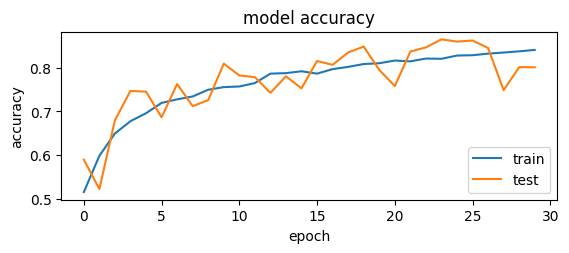

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(mob_history.history['accuracy'])
plot.plot(mob_history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

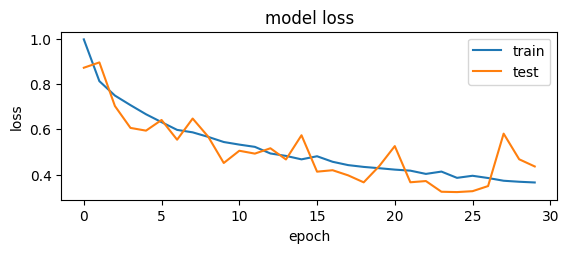

In [ ]:
plot.subplot(2,1,2)
plot.plot(mob_history.history['loss'])
plot.plot(mob_history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in res_model.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Flatten())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(16, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(3, activation='softmax'))
# Compile the model
sgd = SGD(learning_rate=0.01)
resnet_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Print model summary
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1179712   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                       

In [ ]:
resnet_history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 40s 403ms/step - loss: 0.6216 - accuracy: 0.4405 - val_loss: 0.5563 - val_accuracy: 0.5111
Epoch 2/30
86/86 [==============================] - 33s 389ms/step - loss: 0.5815 - accuracy: 0.4858 - val_loss: 0.5427 - val_accuracy: 0.5285
Epoch 3/30
86/86 [==============================] - 33s 387ms/step - loss: 0.5668 - accuracy: 0.5015 - val_loss: 0.5550 - val_accuracy: 0.5358
Epoch 4/30
86/86 [==============================] - 34s 397ms/step - loss: 0.5589 - accuracy: 0.5187 - val_loss: 0.5245 - val_accuracy: 0.5593
Epoch 5/30
86/86 [==============================] - 34s 394ms/step - loss: 0.5495 - accuracy: 0.5351 - val_loss: 0.5150 - val_accuracy: 0.5825
Epoch 6/30
86/86 [==============================] - 36s 416ms/step - loss: 0.5298 - accuracy: 0.5545 - val_loss: 0.5004 - val_accuracy: 0.5935
Epoch 7/30
86/86 [==============================] - 35s 404ms/step - loss: 0.5277 - accuracy: 0.5687 - val_loss: 0.4815 - val_accuracy: 0.6200

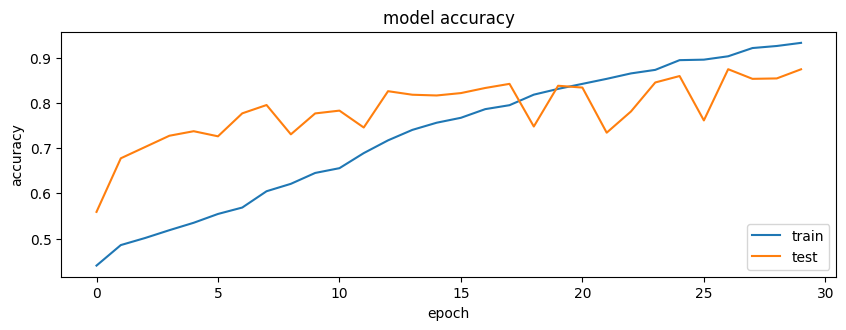

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(resnet_history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

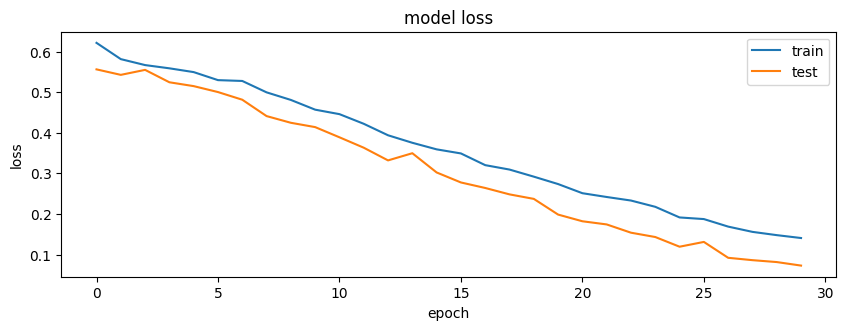

In [ ]:
plot.subplot(2,1,2)
plot.plot(resnet_history.history['loss'])
plot.plot(resnet_history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg_model)
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(3)) # output
model.add(Activation("softmax"))
# Compile the model
sgd = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Print model summary
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                         

In [ ]:
vgg_history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator)

Epoch 1/30
86/86 [==============================] - 45s 433ms/step - loss: 1.0580 - accuracy: 0.4311 - val_loss: 0.8543 - val_accuracy: 0.6375
Epoch 2/30
86/86 [==============================] - 33s 388ms/step - loss: 0.9198 - accuracy: 0.5304 - val_loss: 0.7855 - val_accuracy: 0.6725
Epoch 3/30
86/86 [==============================] - 34s 400ms/step - loss: 0.8693 - accuracy: 0.5869 - val_loss: 0.7284 - val_accuracy: 0.6942
Epoch 4/30
86/86 [==============================] - 34s 392ms/step - loss: 0.8189 - accuracy: 0.6171 - val_loss: 0.6937 - val_accuracy: 0.7424
Epoch 5/30
86/86 [==============================] - 35s 410ms/step - loss: 0.7864 - accuracy: 0.6498 - val_loss: 0.6504 - val_accuracy: 0.7638
Epoch 6/30
86/86 [==============================] - 33s 385ms/step - loss: 0.7498 - accuracy: 0.6733 - val_loss: 0.6268 - val_accuracy: 0.7805
Epoch 7/30
86/86 [==============================] - 35s 411ms/step - loss: 0.7119 - accuracy: 0.7016 - val_loss: 0.5759 - val_accuracy: 0.8024

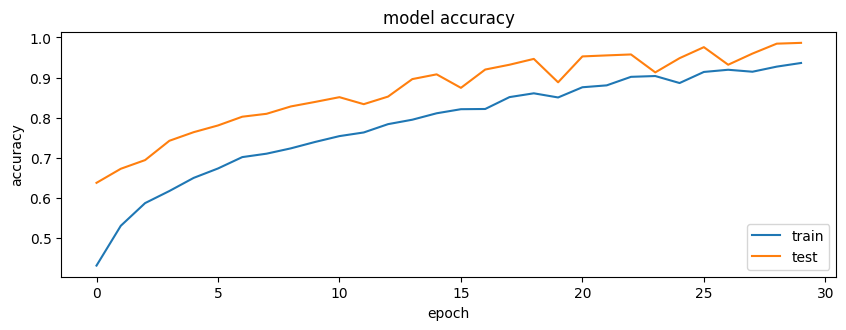

In [ ]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(vgg_history.history['accuracy'])
plot.plot(vgg_history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

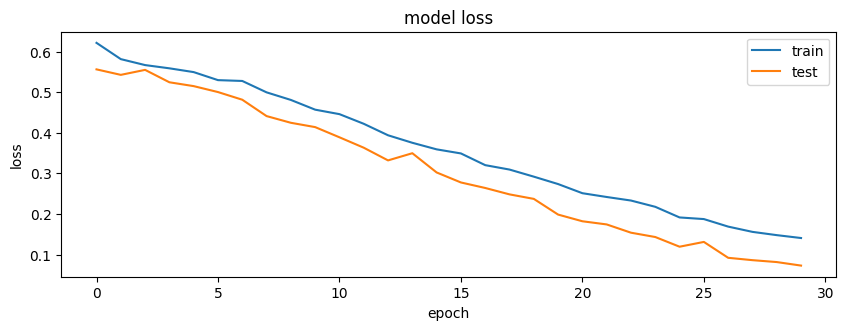

In [ ]:
plot.subplot(2,1,2)
plot.plot(vgg_history.history['loss'])
plot.plot(vgg_history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')